# RNN을 이용한 SNS Spam 분류
- 데이터 다운로드 캐글 : [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

### 한글폰트 사용

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumBarunGothic') 

In [3]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving spam.csv to spam (1).csv


In [4]:
import pandas as pd

df = pd.read_csv(filename, encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [5]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
df['v1'] = df['v1'].replace(['ham', 'spam'], [0, 1])
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [7]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [8]:
df['v2'].nunique()

5169

In [9]:
# 중복데이터 제거
df = df.drop_duplicates('v2', keep='first')

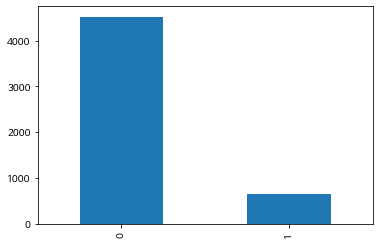

In [10]:
df['v1'].value_counts().plot(kind='bar');

In [11]:
df['v1'].value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [13]:
X_data = df['v2'].values
y_data = df['v1'].values
print('SMS 본문의 개수:', len(X_data))
print('레이블의 개수:', len(y_data))

SMS 본문의 개수: 5169
레이블의 개수: 5169


In [14]:
 X_data[2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [15]:
# 단어 집합(vocabulary)을 만들고 크기를 확인
t = Tokenizer()
t.fit_on_texts(X_data)
sequences = t.texts_to_sequences(X_data)
vocab_size = len(t.word_index)+1
word_to_index = t.word_index
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 8921


### 전체 데이터셋의 길이를 임의의 숫자(100)에 맞춤

In [19]:
X_data = sequences
data = pad_sequences(X_data, maxlen=100)
data.shape

(5169, 100)

In [20]:
# 테스트용 데이터 20% 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(data, y_data, stratify=y_data, test_size=0.2, random_state=seed)

In [21]:
X_train.shape, X_test.shape

((4135, 100), (1034, 100))

### 모델 정의 / 설정 / 학습

In [22]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [23]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32))             # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          285472    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 287,585
Trainable params: 287,585
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [25]:
# 훈련용 데이터 중에서 20%는 검증 데이터로 사용
history = model.fit(X_train, y_train, epochs=10, 
                    batch_size=60, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 3s 32ms/step - loss: 0.4403 - accuracy: 0.8517 - val_loss: 0.2388 - val_accuracy: 0.9033
Epoch 2/10
56/56 [==============================] - 1s 24ms/step - loss: 0.1242 - accuracy: 0.9707 - val_loss: 0.0730 - val_accuracy: 0.9807
Epoch 3/10
56/56 [==============================] - 1s 24ms/step - loss: 0.0640 - accuracy: 0.9847 - val_loss: 0.0540 - val_accuracy: 0.9891
Epoch 4/10
56/56 [==============================] - 1s 24ms/step - loss: 0.0300 - accuracy: 0.9933 - val_loss: 0.0592 - val_accuracy: 0.9807
Epoch 5/10
56/56 [==============================] - 1s 24ms/step - loss: 0.0195 - accuracy: 0.9957 - val_loss: 0.0645 - val_accuracy: 0.9819
Epoch 6/10
56/56 [==============================] - 1s 24ms/step - loss: 0.0118 - accuracy: 0.9982 - val_loss: 0.0723 - val_accuracy: 0.9831
Epoch 7/10
56/56 [==============================] - 1s 24ms/step - loss: 0.0107 - accuracy: 0.9975 - val_loss: 0.0845 - val_accuracy: 0.9831
Epoch 8/10
56

In [26]:
# 테스트 정확도
print(f"\n 테스트 정확도: {model.evaluate(X_test, y_test, verbose=2)[1]}")

33/33 - 0s - loss: 0.0744 - accuracy: 0.9807

 테스트 정확도: 0.9806576371192932


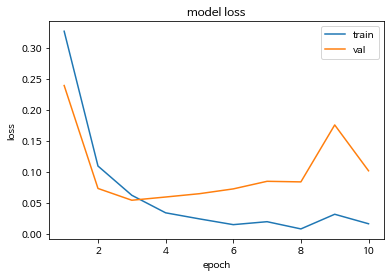

In [27]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()